### Extracting Data from JSONs

In [94]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

In [95]:
def read_json_file(file):

    # read the entire file into a python array
    with open(file, 'r') as f:
        data = f.readlines()

    # remove the trailing "\n" from each line while creating a list of dictionaries
    data = [json.loads(entry.strip('\n')) for entry in data]
    
    return pd.DataFrame(data)

In [96]:
df = read_json_file('data/yelp_dataset/photo.json')

In [97]:
df.head()

,caption,photo_id,business_id,label
0,,MllA1nNpcp1kDteVg6OGUw,rcaPajgKOJC2vo_l3xa42A,inside
1,,YjxBE88Bf6CmTEF2LP1UNA,Kn23LDd740SBVJ7mum0fwg,inside
2,,1f7izSjM0WjkDRIVbPy1yw,ZkGDCVKSdf8m76cnnalL-A,food
3,,NcSlcDTEEeOaixotOPk-rA,bF8gv7k_rwZtiDLP2ZB04w,inside
4,,5IiIo5UKEW0lWqZ6sWrY_A,50Anorn0DJXFhBr9a9_gHQ,inside


### Reading in Images

In [138]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from imageio import imread, imwrite
import os
from glob import glob

In [99]:
# Pulling image metadata
url = 'Data/yelp_photos/photos/__-_xGdkEiqko_xpgxRAZQ.jpg'
img_id = url.replace('Data/yelp_photos/photos/', '').replace('.jpg','')
df[df['photo_id'] == img_id]

,caption,photo_id,business_id,label
13230,Spicy lemongrass tomato soup with fragrant sli...,__-_xGdkEiqko_xpgxRAZQ,TdMEsI-NKn64Pz3y62y5sg,food


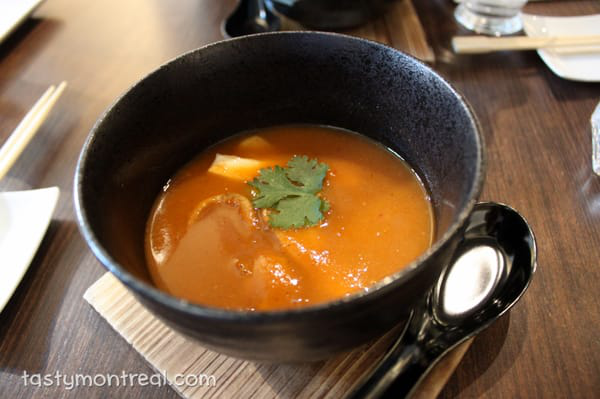

In [100]:
# View the image

datagen = ImageDataGenerator()

img = load_img(url)

img

In [101]:
# Create a smaller subsample of classes
def create_subsample(n=1600):
    labels = df['label'].unique()
    sample_df = pd.DataFrame()

    for label in labels:
        l_sample = df[df['label'] == label].sample(n=n, random_state=42)
        sample_df = sample_df.append(l_sample)
        
    return sample_df


sdf = create_subsample()
sdf['label'].value_counts()

outside    1600
inside     1600
menu       1600
food       1600
drink      1600
Name: label, dtype: int64

In [128]:
X = sdf['photo_id']
y = sdf['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_val, X_holdout, y_val, y_holdout = train_test_split(X_test, y_test, test_size=0.4, random_state=42)

print('Train/Val/Holdout Shapes: ', X_train.shape, X_val.shape, X_holdout.shape)
print('Good Split? : ', X_val.shape[0] + X_holdout.shape[0] == X_test.shape[0])

Train/Val/Holdout Shapes:  (5360,) (1584,) (1056,)
Good Split? :  True


In [66]:
# Take the Keras Image object and turn it into an array
x = img_to_array(img)
print(x.shape)
# Reshape to (3, x, y, z) for RGB data
x = x.reshape((1,) + x.shape)
print(x.shape)

(399, 600, 3)
(1, 399, 600, 3)


Keras will automatically use target classes based on the directory of origin. Therefore I need to organize my train test split results into new directories. The code there will do so. Ensure that you are using a random seed throughout to ensure reproducibility. 

This code will wipe out the directories each time.

In [104]:
# Lists!!!!!
X_list = [X_train, X_val, X_holdout]
y_list = [y_train, y_val, y_holdout]
dir_list = ['train', 'validation', 'holdout']
  
# Loop!!!!
for i in range(0,3):
    # Create Directories if they are not there
    for target in y_list[i].unique():
        directory = f'data/{dir_list[i]}/{target}'
        os.makedirs(directory, exist_ok=True)
        # If there is stuff in them, delete it!
        files = glob(f'{directory}/*')
        if len(files) > 0:
            for f in files:
                os.remove(f)
                
    # Create a list of urls in that particular category
    image_urls = [f'Data/yelp_photos/photos/{name}.jpg' for name in X_list[i]]
    # Create a list of the classes
    image_classes = [target for target in y_list[i]]
    
    # Quick test to make sure everything is the same size
    assert len(image_classes) == len(image_urls)
        
    # Iterate through the url lists
    for j in range(len(image_urls)):
        # strip the url for the title
        stripped_url = image_urls[j].replace('Data/yelp_photos/photos/', '')
        target_class = image_classes[j]
        output_path = f'Data/{dir_list[i]}'
        # read in the image from the original directory
        img = imread(image_urls[j])
        # write it to the new directory 
        imwrite(uri=f'{output_path}/{target_class}/{stripped_url}', im=img, format='jpeg')

    ##### TODO #####
    # Some kind of unit test to check to make sure things ended up in the right spot. 
      

### Simple Image Classifier

Based on the [guide](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) provided by Francois Chollet

In [146]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [147]:
batch_size = 48

train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.3,
                                   zoom_range=0.3,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('data/train',
                                                    target_size=(244, 244),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory('data/validation',
                                                        target_size=(244, 244),
                                                        color_mode="rgb",
                                                        batch_size=batch_size,
                                                        class_mode='categorical')


Found 5360 images belonging to 5 classes.
Found 1584 images belonging to 5 classes.


In [148]:
# Baseline Model 
# 3 Convolutional layers with ReLU activation followed by max-pooling layers

model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(244,244, 3))) # May need to change
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Followed by 2 fully-connected layers. 
# Finish with a multi-class layer with a softmax function

model.add(Flatten()) # 3D feature maps to 1D feature vectors
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(5))
model.add(Activation('softmax')) # TODO Double check

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 242, 242, 64)      1792      
_________________________________________________________________
activation_60 (Activation)   (None, 242, 242, 64)      0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 121, 121, 64)      0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 119, 119, 64)      36928     
_________________________________________________________________
activation_61 (Activation)   (None, 119, 119, 64)      0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 59, 59, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 57, 57, 128)     

In [150]:
checkpointer = ModelCheckpoint(filepath='models/m12.h5', 
                               verbose=0, 
                               save_best_only=True)

callbacks_list = [checkpointer]

model_history = model.fit_generator(train_generator, 
                                    steps_per_epoch=5360 // batch_size,
                                    epochs=50,
                                    validation_data=validation_generator,
                                    validation_steps=1584 // batch_size,
                                    callbacks=callbacks_list)

model.save_weights('models/first_try.h5')

Epoch 1/50
111/111 [==============================] - 388s 3s/step - loss: 1.0477 - accuracy: 0.6141 - val_loss: 1.0415 - val_accuracy: 0.6667
Epoch 2/50
111/111 [==============================] - 347s 3s/step - loss: 0.9942 - accuracy: 0.6333 - val_loss: 0.9612 - val_accuracy: 0.7014
Epoch 3/50
111/111 [==============================] - 365s 3s/step - loss: 0.9440 - accuracy: 0.6478 - val_loss: 0.7977 - val_accuracy: 0.6862
Epoch 4/50
111/111 [==============================] - 406s 4s/step - loss: 0.9089 - accuracy: 0.6677 - val_loss: 1.4923 - val_accuracy: 0.5423
Epoch 5/50
111/111 [==============================] - 406s 4s/step - loss: 0.8939 - accuracy: 0.6668 - val_loss: 1.0257 - val_accuracy: 0.7071
Epoch 6/50
111/111 [==============================] - 378s 3s/step - loss: 0.8594 - accuracy: 0.6894 - val_loss: 0.7447 - val_accuracy: 0.7191
Epoch 7/50
111/111 [==============================] - 337s 3s/step - loss: 0.8726 - accuracy: 0.6901 - val_loss: 0.8284 - val_accuracy: 0.7380

In [151]:
import matplotlib.pyplot as plt

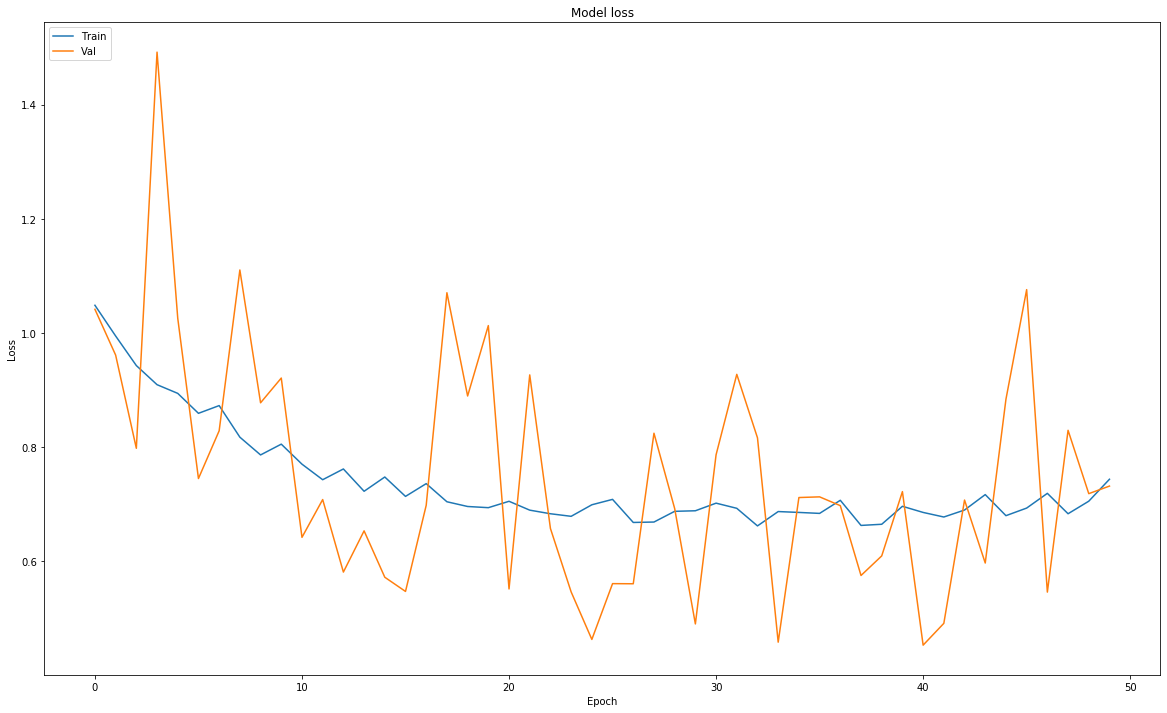

In [152]:
# Plot training & validation loss values
plt.figure(figsize=(20,12))
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

#Bottlenecking using VGG16

### Fine Tuning using VGG16

In [154]:
from keras import applications
from keras import optimizers

In [156]:
# Model Setup


# Load in VGG16
model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

top_model = Sequential()

top_model.add(Flatten(input_shape=model.output_shape[1:])) # 3D feature maps to 1D feature vectors
top_model.add(Dense(128))
top_model.add(Activation('relu'))
top_model.add(Dropout(0.3))
top_model.add(Dense(256))
top_model.add(Activation('relu'))
top_model.add(Dropout(0.3))
top_model.add(Dense(5))
top_model.add(Activation('softmax')) 

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights("models/m12.h5")

# add the model on top of the convolutional base
model.add(top_model)

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:25]:
    layer.trainable = False
    
    
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])


ValueError: You are trying to load a weight file containing 6 layers into a model with 3 layers.

In [ ]:
checkpointer = ModelCheckpoint(filepath='models/vgg1.h5', 
                               verbose=0, 
                               save_best_only=True)

callbacks_list = [checkpointer]

model_history = model.fit_generator(train_generator, 
                                    steps_per_epoch=5360 // batch_size,
                                    epochs=50,
                                    validation_data=validation_generator,
                                    validation_steps=1584 // batch_size)

model.save_weights('models/second_try.h5')